In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install GPUtil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7394 sha256=b268a5f9b545947a8a27c9780d067f8c11b7f2cc6ac4d33a9efcd8f1fa1cb429
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil


In [ ]:
pip install ultralytics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 749.6/749.6 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 82.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:
!pip install easyocr
!pip install pytesseract

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 16.2 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import shutil
import re
import glob
import subprocess
import random
import yaml
import tqdm
import gc


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import IPython.display as display
from IPython.display import Video
from PIL import Image
import cv2

import ultralytics
from ultralytics import YOLO

import easyocr

import xml.etree.ElementTree as xet
from bs4 import BeautifulSoup

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda
import pytesseract

print('ultralytics version: ',ultralytics.__version__)

ultralytics version:  8.1.45


In [ ]:
class CFG:

    #paths
    out_folder = f'/content/drive/MyDrive/output'
    class_name = ['car_plate']
    video_test_path = 'https://docs.google.com/uc?export=download&confirm=&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-'

    weights = '/content/drive/MyDrive/project/yolov8s.pt'
    exp_name = 'car_plate_detection'
    img_size = (240,400)
    vehicles_class = [2, 3, 5, 7]

    #Yolo train parameters
    epochs = 50
    batch_size = 16
    optimizer = 'auto' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    lr = 1e-5
    lr_factor = 0.01 #lo*lr_f
    weight_decay = 5e-4
    dropout = 0.5
    patience = int(0.7*epochs)
    profile = False
    label_smoothing = 0.0

    #models Confidance
    vehicle_conf = 0.5
    plate_conf = 0.3
    ocr_conf = 0.1

    seed = 42

In [ ]:
def get_bbox(file_path):
    '''
    This function takes a file path as input.
    It extracts information about the bounding box (coordinates) from the XML file, specifically the values for xmin, xmax, ymin, and ymax.
    Returns a tuple containing the extracted coordinates (xmin, xmax, ymin, ymax).
    '''
    info = xet.parse(file_path)
    root = info.getroot()
    member_object = root.find('object')

    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    return  xmin, xmax, ymin, ymax



def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.seed):
    '''
    It randomly selects num_images image files from the specified folder.
    It then plots the image with the bounding box using Matplotlib, arranging the images in a grid.
    '''
    random.seed(seed)

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]



    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        img = cv2.imread(os.path.join(folder_path, file_name))


        xmin, xmax, ymin, ymax = get_bbox(file_path=os.path.join('/kaggle/input/car-plate-detection/annotations',
                                                                 file_name.replace('.png','.xml')))



        start_point = (xmin, ymax)
        end_point = (xmax, ymin)

        img = cv2.rectangle(img, start_point, end_point, (255,0,0), 3)


        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]

        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()

def parse_xml_tags(data):
    """Parse xml label file, return image file name, and its coordinates as a dictionary
    """
    tags = ['filename', 'width', 'height', 'xmin', 'ymin', 'xmax', 'ymax']
    Bs_data = BeautifulSoup(data, "xml")
    d = dict()

    for t in tags:
        text = Bs_data.find(t).text
        if all(c.isdigit() for c in text):
            d[t] = int(text)
        else:
            d[t] = text
    return d




def convert_xml_txt_yolo(file_path,w_image,h_image):
    '''
    This function converts XML label information to YOLO format.
    It reads an XML file specified by the file path, extracts bounding box coordinates, and converts them to YOLO format.
    Returns a string in YOLO format
    '''
    with open(file_path,  'r') as f:
        label = parse_xml_tags(f.read())


    xmin = int(label['xmin'])
    xmax = int(label['xmax'])
    ymin = int(label['ymin'])
    ymax = int(label['ymax'])


    x_center = float((xmin+((xmax-xmin)/2))/w_image)
    y_center = float((ymin+((ymax-ymin)/2))/h_image)

    width = float((xmax-xmin)/w_image)
    height = float((ymax-ymin)/h_image)

    str_out = f'0 {x_center} {y_center} {width} {height}'

    return str_out

def display_image(image, print_info = True, hide_axis = False, figsize = (15,15), title=None):
    '''
    This function displays an image using Matplotlib.
    It takes an image file path or a NumPy array as input.
    It can print information about the image (type and shape), hide axis, and set a title.
    '''
    fig = plt.figure(figsize = figsize)
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)

        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        if image.shape[-1] == 3:
            image = image[..., ::-1]  # BGR to RGB
            img = Image.fromarray(image)
            plt.imshow(img)
        else:
            img = np.copy(image)
            plt.imshow(img,cmap = 'gray')

    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')
    if title is not None:
        plt.title(title)

    plt.show()

def create_dir(path):
    '''
    This function creates a directory at the specified path if it doesn't exist.
    '''
    if not os.path.exists(path):
        os.mkdir(path)

def gpu_report():
    '''
    This function provides information about the available GPUs, their properties, and CUDA version.
    It also prints GPU usage.
    '''
    if torch.cuda.is_available():
        # Get the number of available GPUs
        num_gpus = torch.cuda.device_count()
        print(f"Number of available GPUs: {num_gpus}")

        if num_gpus > 1:
            train_device, test_device = 0,1

        else:
            train_device, test_device = 0,0




        # Get information about each GPU
        for i in range(num_gpus):
            gpu_properties = torch.cuda.get_device_properties(i)
            print(f"\nGPU {i}: {gpu_properties.name}")
            print(f"  Total Memory: {gpu_properties.total_memory / (1024**3):.2f} GB")
            print(f"  CUDA Version: {gpu_properties.major}.{gpu_properties.minor}")


    else:
        print("CUDA is not available. You can only use CPU.")
        train_device, test_device = 'cpu', 'cpu'


    print('\n')
    gpu_usage()

    return train_device, test_device


def extract_roi(image, bounding_box):
    """
    Crop the input image based on the provided bounding box coordinates.

    Args:
        image (numpy.ndarray): The input image.
        bounding_box (tuple): A tuple containing (x_min, y_min, x_max, y_max)
            coordinates of the bounding box.

    Returns:
        numpy.ndarray: The cropped image.
    """
    x_min, x_max, y_min, y_max = bounding_box
    cropped_image = image[y_min:y_max, x_min:x_max]
    return cropped_image


def free_gpu_cache() -> None:
    print("Initial GPU Usage")
    gpu_usage()


    torch.cuda.empty_cache()


    print("GPU Usage after emptying the cache")
    gpu_usage()


def extract_ocr(roi_img, reader):
    '''
    This function performs Optical Character Recognition (OCR) on a cropped image (roi_img) using the specified OCR reader.
    It returns the recognized text (plate number) and confidence level.
    '''
    ocr_result = reader.readtext(np.asarray(roi_img), allowlist = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    text_plate = ''
    if len(ocr_result) > 0:

        for item in ocr_result:
            text, conf = item[-2], item[-1]
            text = text if conf > CFG.ocr_conf else ''
            text_plate+=text
    else:
        text_plate, conf = 'unreco_plate', 0

    text_plate = text_plate.lower()

    #text_plate = isValidNumberPlate(text_plate)


    return text_plate,conf


def inference_inside_roi(df_coords, img, model, device ,display = False):
    '''
    This function performs object detection on the region of interest (ROI) inside a given image.
    It takes a DataFrame (df_coords) containing bounding box coordinates, the image, a detection model, and the device.
    It returns the original image and a DataFrame (df_plate) with information about the detected plates.
    '''
    bboxs = df_coords[['xmin','xmax','ymin','ymax']].values.astype(int)
    classes = df_coords['class'].values


    df_plate = pd.DataFrame()
    for i,bbox in enumerate(bboxs):

        vehicle_img = extract_roi(img, bbox)

        results = model.predict(vehicle_img,
                        conf = CFG.plate_conf,
                        classes =[0],
                        device = device,
                        verbose = False)

        position_frame = pd.DataFrame(results[0].cpu().numpy().boxes.data,
                                       columns = ['xmin', 'ymin', 'xmax',
                                                  'ymax', 'conf', 'class'])

        position_frame['class'] = position_frame['class'].replace({0:'car_plate'})
        position_frame['plate_number'] = 'unreco_plate'

        #Filter cases with more them one plate per vehicle
        position_frame = position_frame.loc[position_frame['conf'] == position_frame['conf'].max(),:]

        #adjust bbox of plate for complete image
        position_frame['xmin']+=bbox[0]
        position_frame['xmax']+=bbox[0]
        position_frame['ymin']+=bbox[2]
        position_frame['ymax']+=bbox[2]

        if display:
            display_image(vehicle_img, hide_axis = True, figsize =(10,10), title='Vehicle ROI Image')

        if len(position_frame) > 0:

            plate_bbox = position_frame[['xmin','xmax','ymin','ymax']].values.squeeze().astype(int)
            plate_img = extract_roi(img, plate_bbox)
            text_plate, conf_ocr = extract_ocr(plate_img, reader)
            position_frame['plate_number'] = text_plate

            if display:
                display_image(plate_img, hide_axis = True, figsize =(10,10), title=f'ROI Plate | Nº: {text_plate}')




        position_frame = position_frame[['xmin', 'ymin', 'xmax','ymax' ,'conf', 'class', 'plate_number']]


        df_plate = pd.concat([df_plate, position_frame], axis = 0)

    return img, df_plate

def drawBBox(df_coords, img, title = '' ,thickness=1):
    '''
    This function draws bounding boxes on the input image based on the coordinates in the DataFrame (df_coords).
    It also labels the detected objects with their classes and, if applicable, the plate numbers.
    '''
    cords = df_coords[['xmin','xmax','ymin','ymax']].values.astype(int)
    classes = df_coords['class'].values

    for i,detection in enumerate(cords):


        start_point = (detection[0], detection[-1]) # x_min, y_max
        end_point = (detection[1], detection[2]) # x_max, y_min
        class_detected = classes[i]


        if class_detected == 'car_plate':
            number_plate = df_coords['plate_number'].values[i]
            cv2.rectangle(img, start_point, end_point, (0,0,190), thickness)
            cv2.putText(img=img, text=f'{class_detected} ',
                org= (detection[0], detection[2]-20),
                fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=2, color=(0, 255, 0),thickness=3)
            cv2.putText(img=img, text=f'{number_plate}',
                org= (detection[0]-10, detection[-1]+30),
                fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=2, color=(0, 255, 0),thickness=3)
        else:
            cv2.rectangle(img, start_point, end_point, (255,0,0), thickness)

            cv2.putText(img=img, text=f'{class_detected}',
                org= (detection[0], detection[2]-20),
                fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=2, color=(255, 255, 0),thickness=3)



    return img

In [ ]:
! wandb disabled

/bin/bash: line 1: wandb: command not found


In [ ]:
#res_path = CFG.out_folder + '/content/drive/MyDrive/runs/detect' + os.listdir(CFG.out_folder + '/content/drive/MyDrive/runs/detect')[-1]
#!tree {res_path}

In [ ]:
train_device, test_device = gpu_report()
plate_model.to(train_device)

print('\nModel Info')
print('Model: ', CFG.weights)
print('Device: ' ,plate_model.device)

Number of available GPUs: 1

GPU 0: Tesla T4
  Total Memory: 14.75 GB
  CUDA Version: 7.5


| ID | GPU | MEM |
------------------
|  0 |  0% |  4% |

Model Info
Model:  /content/drive/MyDrive/project/yolov8s.pt
Device:  cuda:0


In [ ]:
plate_model = YOLO('/content/drive/MyDrive/runs/detect/car_plate_detection/weights/best.pt')
vehicle_model = YOLO(CFG.weights)
reader = easyocr.Reader(['en'],  gpu=True if test_device != 'cpu' else False)

plate_model.to(test_device)
vehicle_model.to(test_device)

print('\nModels Info')
print('Plate Model: ', plate_model.device, 'Vehicle Model: ', plate_model.device)


Models Info
Plate Model:  cuda:0 Vehicle Model:  cuda:0


In [ ]:
dict_all_classes = vehicle_model.model.names
dict_classes = {}
for id_class in CFG.vehicles_class:
    dict_classes[id_class] = dict_all_classes[id_class]

dict_classes

{2: 'car', 3: 'motorcycle', 5: 'bus', 7: 'truck'}

In [ ]:
test_images = glob.glob('/content/drive/MyDrive/project/Automatic number plate/images 1/*.jpeg')

In [ ]:
def run_pipeline(path, display=False):

    '''
    1. Detect vehicles from a input image.
    2. Crop the ROIs with BBOX of vehicles detections.
    3. Detect plates from croped vehicle images.
    4. Crop the ROIs with BBOX of plate detections.
    5. Extract the plate number with OCR from croped plate detections.
    '''

    image = cv2.imread(path)

    if display:
        display_image(image,
                      hide_axis =True,
                      figsize = (10,10),
                      title='Input Image')

    #1
    vehicle_results = vehicle_model.predict(image,
                            conf =CFG.vehicle_conf,
                            classes = CFG.vehicles_class,
                            device = test_device,
                            verbose = False,

                                 )

    df_vehicles = pd.DataFrame(vehicle_results[0].cpu().numpy().boxes.data,
                                   columns = ['xmin', 'ymin', 'xmax',
                                              'ymax','conf', 'class'])
    df_vehicles['class'] = df_vehicles['class'].replace(dict_classes)


    # 2, 3,4
    image, df_plates = inference_inside_roi(df_vehicles,
                                                image,
                                                plate_model,
                                                test_device,
                                                display = display)
    df_frame = pd.concat([df_vehicles, df_plates], axis = 0).reset_index(drop=True)
    #Draw results in output images
    image = drawBBox(df_frame, image, thickness=5)

    if display:
        display_image(image,
                      hide_axis =True,
                      figsize = (10,10),
                      title='Output Image')

    return df_frame, image

Type:  <class 'PIL.Image.Image'> 

Shape:  (404, 647, 3) 



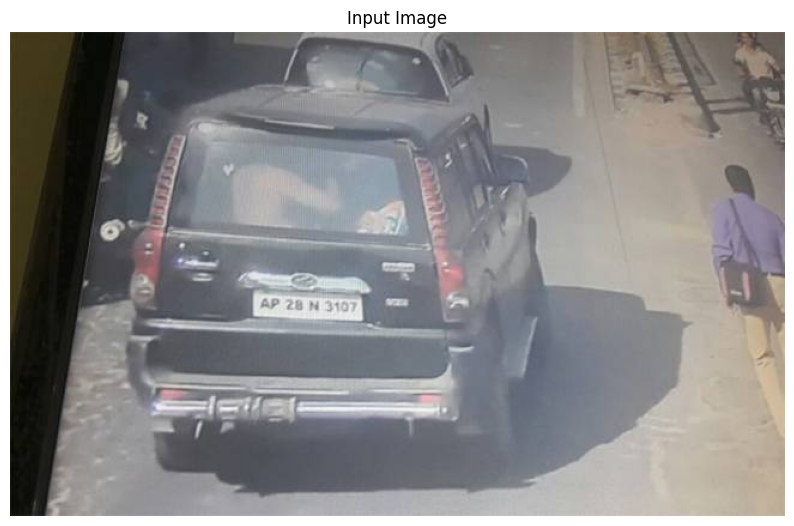

Type:  <class 'PIL.Image.Image'> 

Shape:  (375, 363, 3) 



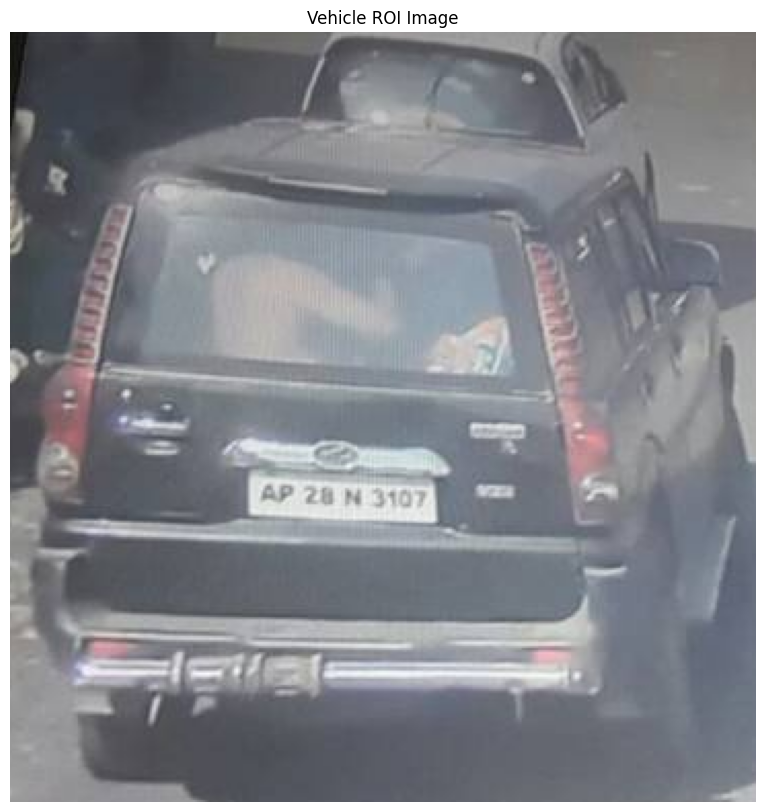

Type:  <class 'PIL.Image.Image'> 

Shape:  (26, 93, 3) 



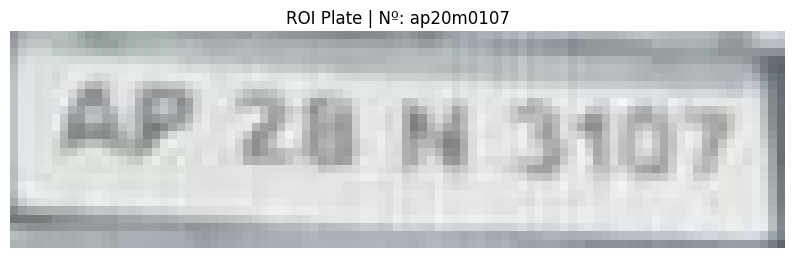

Type:  <class 'PIL.Image.Image'> 

Shape:  (404, 647, 3) 



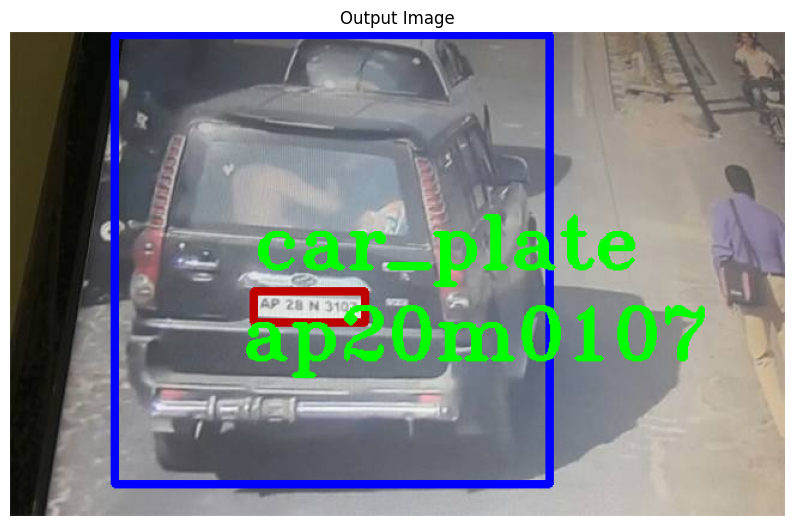

In [ ]:
df_frame, out_image  = run_pipeline(path = test_images[11], display=True)

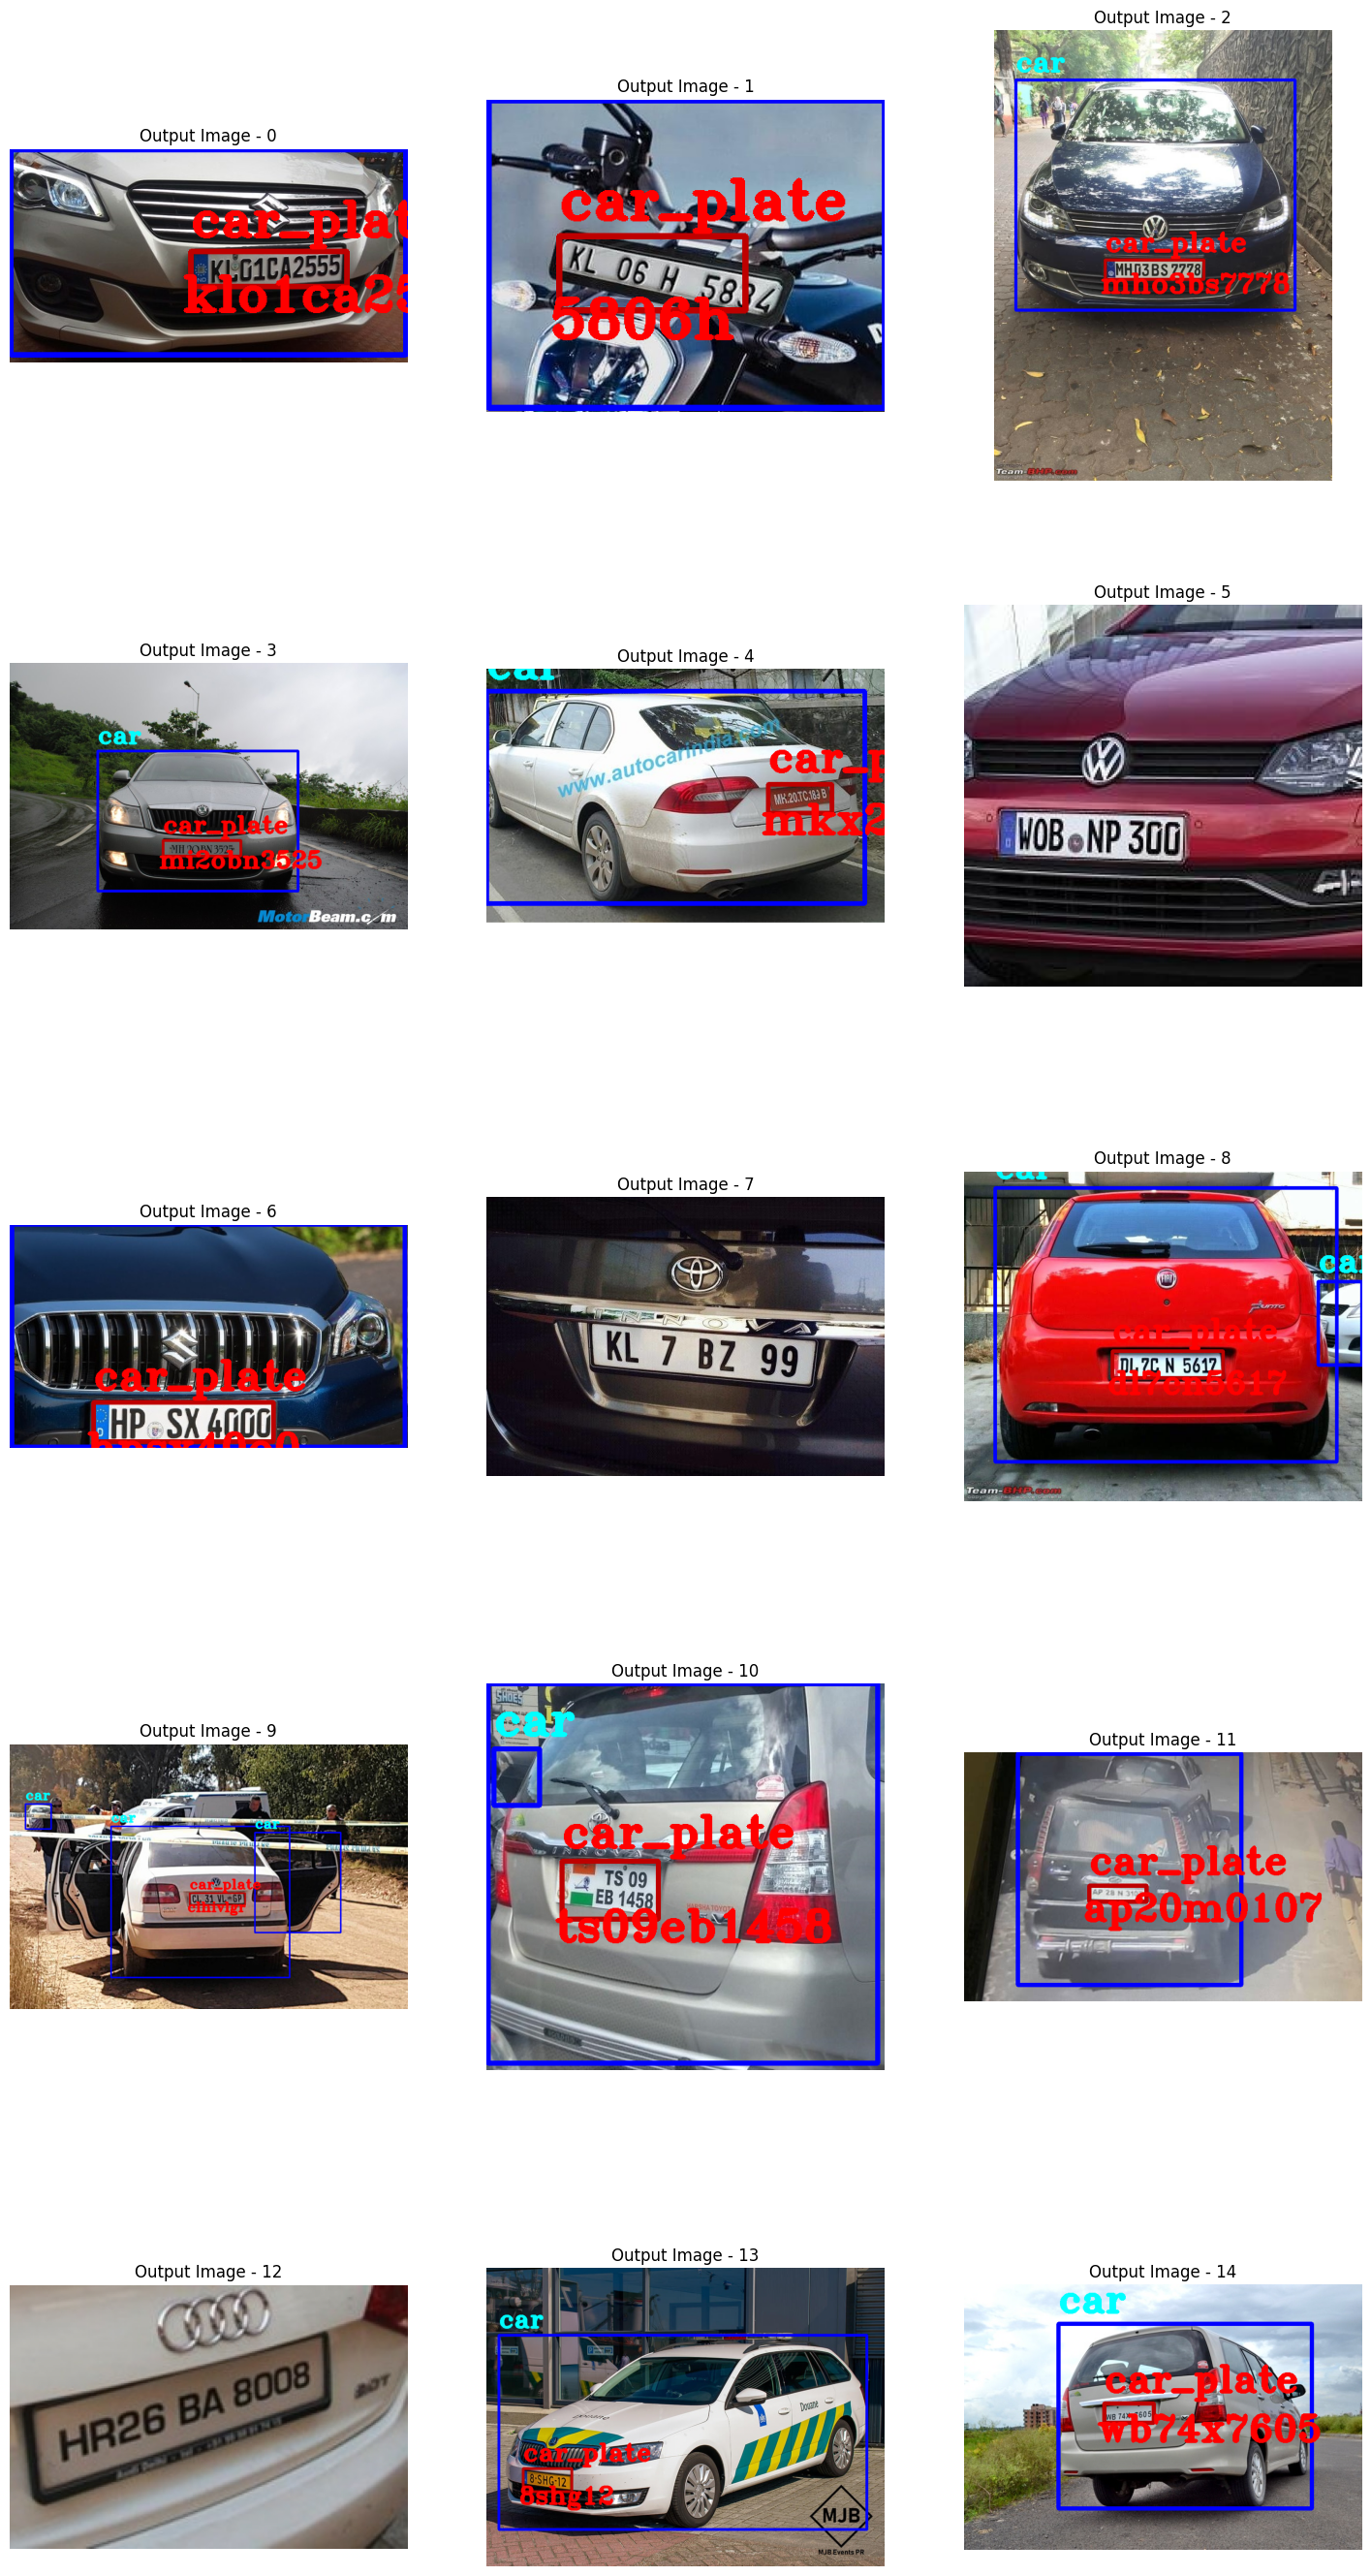

In [ ]:
n_inferences = 15

num_cols = 3
num_rows = (n_inferences + num_cols - 1) // num_cols
fig,axes = plt.subplots(num_rows,num_cols, figsize=(num_cols*6, num_rows*7))



for i in range(n_inferences):
    df_frame, out_image  = run_pipeline(path = test_images[i], display=False)

    if num_rows == 1:
        ax = axes[i % num_cols]
    else:
        ax = axes[i // num_cols, i % num_cols]

    out_image = cv2.cvtColor(out_image, cv2.COLOR_BGR2RGB)
    ax.imshow(out_image)

    ax.axis('off')
    ax.set_title(f'Output Image - {i}')

In [ ]:
def run_pipeline(frame, display=False):
    '''
    1. Detect vehicles from an input image.
    2. Crop the ROIs with BBOX of vehicles detections.
    3. Detect plates from cropped vehicle images.
    4. Crop the ROIs with BBOX of plate detections.
    5. Extract the plate number with OCR from cropped plate detections.
    '''

    if display:
        display_image(frame,
                      hide_axis=True,
                      figsize=(10, 10),
                      title='Input Image')

    # 1
    vehicle_results = vehicle_model.predict(frame,
                                            conf=CFG.vehicle_conf,
                                            classes=CFG.vehicles_class,
                                            device=test_device,
                                            verbose=False)

    df_vehicles = pd.DataFrame(vehicle_results[0].cpu().numpy().boxes.data,
                               columns=['xmin', 'ymin', 'xmax',
                                        'ymax', 'conf', 'class'])
    df_vehicles['class'] = df_vehicles['class'].replace(dict_classes)

    # 2, 3,4
    _, df_plates = inference_inside_roi(df_vehicles,
                                        frame,
                                        plate_model,
                                        test_device,
                                        display=display)
    df_frame = pd.concat([df_vehicles, df_plates], axis=0).reset_index(drop=True)


    # Draw results in output images
    frame = drawBBox(df_frame, frame, thickness=5)

    if display:
        display_image(frame,
                      hide_axis=True,
                      figsize=(10, 10),
                      title='Output Image')

    return df_frame, frame


In [ ]:
import cv2
import pandas as pd

def process_video(input_video_path, output_video_path, output_csv_path):
    # Open the input video file
    cap = cv2.VideoCapture(input_video_path)

    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Create VideoWriter for output video
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out_video = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    # Create DataFrame to store results
    columns = ['Frame', 'Class', 'Plate Number', 'xmin', 'ymin', 'xmax', 'ymax']
    results_df = pd.DataFrame(columns=columns)

    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Run the pipeline on the current frame
        df_frame, output_image = run_pipeline(frame, display=False)

        # Append the results to the DataFrame
        df_frame['Frame'] = frame_count
        results_df = pd.concat([results_df, df_frame], ignore_index=True)

        # Write the processed frame to the output video
        out_video.write(output_image)

        frame_count += 1

    # Release the video capture and writer objects
    cap.release()
    out_video.release()

    # Save the results DataFrame to CSV
    results_df.to_csv(output_csv_path, index=False)

if __name__ == "__main__":
    input_video_path = '/content/drive/MyDrive/project/car number plate videovideo/Automatic Number Plate Recognition (ANPR) _ Vehicle Number Plate Recognition (1).mp4'
    output_video_path = '/content/drive/MyDrive/output/video_output.avi'
    output_csv_path = '/content/drive/MyDrive/output/results.csv'

#process_video('/content/drive/MyDrive/project/car number plate videovideo/pexels-casey-whalen-6571483 (2160p).mp4', '/content/drive/MyDrive/output/Video1.avi', '/content/drive/MyDrive/output/Video1.csv')
#process_video('/content/drive/MyDrive/project/car number plate videovideo/pexels-christopher-schultz-5927708 (1080p).mp4', '/content/drive/MyDrive/output/Video2.avi', '/content/drive/MyDrive/output/Video2.csv')
#process_video('/content/drive/MyDrive/project/car number plate videovideo/pexels-george-morina-5222550 (2160p).mp4', '/content/drive/MyDrive/output/Video3.avi', '/content/drive/MyDrive/output/Video3.csv')

In [ ]:
#!ffmpeg -i /content/drive/MyDrive/output/Video1.avi -c:v libx264 -crf 23 -c:a aac -q:a 100 -y /content/drive/MyDrive/output/Video1.mp4
#!ffmpeg - i /content/drive/MyDrive/output/Video2.avi -c:v libx264 -crf 23 -c:a aac -q:a 100 -y /content/drive/MyDrive/output/Video2.mp4

In [ ]:
process_video('/content/drive/MyDrive/project/car number plate videovideo/pexels-taryn-elliott-5309381 (1080p).mp4', '/content/drive/MyDrive/output/Video5.avi', '/content/drive/MyDrive/output/Video5.csv')

In [ ]:
#!ffmpeg -i /kaggle/working/Video2.avi -c:v libx264 -crf 23 -c:a aac -q:a 100 -y /kaggle/working/Video2.mp4
!ffmpeg -i /content/drive/MyDrive/output/Video5.avi -c:v libx264 -crf 23 -c:a aac -q:a 100 -y /content/drive/MyDrive/output/Video5.mp4
#!ffmpeg -i /kaggle/working/Video4.avi -c:v libx264 -crf 23 -c:a aac -q:a 100 -y /kaggle/working/Video4.mp4
#!ffmpeg -i /kaggle/working/Video5.avi -c:v libx264 -crf 23 -c:a aac -q:a 100 -y /kaggle/working/Video5.mp4


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:
pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 88.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.3 MB/s eta 0:00:00


In [ ]:
!pip install Streamlit -q

In [ ]:
%%writefile app.py
import streamlit as st

def main():
    st.title("MP4 Video Player")

    # Provide the path to the MP4 video file
    video_path = "/content/drive/MyDrive/output/Video4.mp4"

    # Display the video
    st.video(video_path)

if __name__ == "__main__":
    main()


Overwriting app.py


In [ ]:
!streamlit run app.py




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.148.189.234:8501

  Stopping...
  Stopping...
Traceback (most recent call last):
  File "/usr/local/bin/streamlit", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/click/core.py", line 1157, in __call__
    return self.main(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/click/core.py", line 1078, in main
    rv = self.invoke(ctx)
  File "/usr/local/lib/python3.10/dist-packages/click/core.py", line 1688, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/usr/local/lib/python3.10/dist-packages/click/core.py", line 1434, in invoke
    return ctx.invoke(self.callback, **ctx.params)
  File "/usr/local/lib/python3.10/dist-packages/click/core.py", line 782, in invoke
    with ctx:
  File "/usr/local/lib/python3.10/dist-packages/click/core.py", line 467, in __exit__
    pop_context()
  

In [ ]:
from IPython.display import HTML
from base64 import b64encode
video_path = "/content/drive/MyDrive/output/Video3.mp4"
mp4 = open(video_path, "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""
<video width=400 controls>
      <source src="{data_url}" type="video/mp4">
</video>
""")

In [ ]:
import imageio
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
from IPython.display import HTML

def display_video(video):
    fig = plt.figure(figsize=(3, 3))  # Display size specification

    mov = []
    for frame in video:  # Append frames one by one to mov
        img = plt.imshow(frame, animated=True)
        plt.axis('off')
        mov.append([img])

    # Animation creation
    anim = animation.ArtistAnimation(fig, mov, interval=50, repeat_delay=1000)

    plt.close()
    return anim

video_path = '/content/drive/MyDrive/output/Video3.mp4'

# Calculate the number of frames for 2 minutes
video_reader = imageio.get_reader(video_path)
fps = video_reader.get_meta_data()['fps']
num_frames_2mins = int(2 * 60 * fps)

# Read the first 2 minutes of the video
video = [resize(frame, (256, 256))[..., :3] for frame in video_reader][:num_frames_2mins]

HTML(display_video(video).to_html5_video())  # Inline video display in HTML5
